In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe

import warnings

import planetary_computer as pc
import rioxarray as rioxr

import gc # garbage collector

import dask
import dask_gateway
import dask.array as da

import lidar_sampling_functions_Copy1 as lsf

In [2]:
t_alpha = time.time()

## Import train/test sets

In [3]:
X_train = pd.read_csv(os.path.join(os.getcwd(),'create_train_test_sets','train_set.csv')).loc[:,'r':'avg_lidar']
y_train = pd.read_csv(os.path.join(os.getcwd(),'create_train_test_sets','train_set.csv')).loc[:,'iceplant'] 

# X_test = pd.read_csv(os.path.join(os.getcwd(),'create_train_test_sets','test_set.csv')).loc[:,'r':'avg_lidar']
# y_test = pd.read_csv(os.path.join(os.getcwd(),'create_train_test_sets','test_set.csv')).loc[:,'iceplant']

In [4]:
X_train.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar
0,43,51,78,89,0.348485,2012,5,126,2,10,0,10,3.000000
1,65,59,84,79,0.097222,2012,5,126,0,6,0,6,1.000000
2,81,86,93,132,0.239437,2012,5,126,11,14,6,8,9.222222


In [5]:
mpe.iceplant_proportions(np.array(y_train))

no-iceplant:iceplant ratio     2.6 :1
          counts  percentage
iceplant                    
0         285908       72.27
1         109714       27.73



In [6]:
# mpe.iceplant_proportions(np.array(y_test))

## Train model

In [7]:
from dask_ml.wrappers import ParallelPostFit

In [8]:
t0 = time.time()

rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, random_state = 42))
rfc.fit(X_train, y_train)

print('time to train: ', (time.time()-t0))

time to train:  43.28964591026306


In [9]:
del X_train, y_train
gc.collect()

24

In [10]:
# predictions = rfc.predict(X_test)
# mpe.print_threshold_metrics(y_test, predictions)

## Feature importance

In [11]:
# # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
# )

In [12]:
# forest_importances = pd.Series(result.importances_mean, index=['r', 'g', 'b', 'nir', 'ndvi', 
#                                                                'year', 'month', 'day_in_year',
#                                                               'lidar', 'max_lidar', 'min_lidar', 'min_max_diff', 'avg_lidar'])


In [13]:
# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

# Select NAIP scene and LIDAR year

In [14]:
# gaviota_itemids = ['ca_m_3412039_nw_10_060_20200522',
# 'ca_m_3412039_nw_10_060_20180724_20190209',
# 'ca_m_3412039_nw_10_.6_20160616_20161004',
# 'ca_m_3412039_nw_10_1_20140603_20141030',
# 'ca_m_3412039_nw_10_1_20120518_20120730']

In [15]:
campus_itemids = ['ca_m_3411934_sw_11_060_20200521',
                  'ca_m_3411934_sw_11_060_20180722_20190209',
                  'ca_m_3411934_sw_11_.6_20160713_20161004']

In [16]:
# **************************************************************
# ********* SPECIFY ITEMID AND LIDAR YEAR TO MATCH HERE ********

itemid = campus_itemids[2] # NAIP scene over Conception Point
lidar_year = 2016
save_raster = True
filename = 'campus_2016_predictions.tif'

# **************************************************************
# **************************************************************

# Open NAIP scene for classification

In [17]:
href = pc.sign(ipf.get_item_from_id(itemid).assets["image"].href)

# rioxarray of complete naip scene
naip_scene = rioxr.open_rasterio(rasterio.open(href))

# Prepare LIDAR data for sampling

In [18]:
# Create auxiliary LIDAR files to sample from
fp = os.path.join(os.getcwd(),
                  'model_with_lidar',
                  'SantaBarbaraCounty_lidar_'+str(lidar_year)+'.tif')
lidar_reader = rasterio.open(fp)
lsf.save_min_max_rasters(lidar_reader, os.getcwd()+'/temp',lidar_year)
lsf.save_avg_rasters(lidar_reader, os.getcwd()+'/temp',lidar_year)

In [19]:
def open_and_match(fp, reproject_to):
    rast = rioxr.open_rasterio(fp)
    rast_match = rast.rio.reproject_match(reproject_to)
    return rast_match.squeeze()

In [20]:
# Resample lidar layers to match NAIP scene resolution and extent

lidar_match = open_and_match(fp, naip_scene)

fp = os.path.join(os.getcwd(),'temp','lidar_mins_'+str(lidar_year)+'.tif')
mins_match = open_and_match(fp, naip_scene)

fp = os.path.join(os.getcwd(),'temp','lidar_maxs_'+str(lidar_year)+'.tif')
maxs_match = open_and_match(fp, naip_scene)

fp = os.path.join(os.getcwd(),'temp','lidar_avgs_'+str(lidar_year)+'.tif')
avg_match = open_and_match(fp, naip_scene)

In [21]:
# Assemble LIDAR layers into dataframe 

df_lidar = pd.DataFrame()
df_lidar['lidar'] = lidar_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['max_lidar'] = maxs_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['min_lidar'] = mins_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])
df_lidar['min_max_diff'] = df_lidar.max_lidar - df_lidar.min_lidar
df_lidar['avg_lidar'] = avg_match.to_numpy().reshape(avg_match.shape[0]*avg_match.shape[1])

In [22]:
# clear memory
del avg_match, mins_match, maxs_match, lidar_match
gc.collect()

0

In [23]:
# Delete auxiliary LIDAR rasters in temp folder
lidar_fps = []
for tag in ['maxs_', 'mins_', 'avgs_']:
    lidar_fps.append(os.path.join(os.getcwd(),
                                  'temp',
                                  'lidar_'+tag+ str(lidar_year)+'.tif'))
for fp in lidar_fps:
    os.remove(fp)

# Select points to be classified using NDVI threshold

In [24]:
# select pixel with vegetation
veg = ipf.features_over_aoi(ipf.get_item_from_id(itemid), 
                           naip_scene.to_numpy(), 
                           thresh=0.05)
veg

,r,g,b,nir,ndvi,year,month,day_in_year
1,50,50,66,57,0.065421,2016,7,195
2,46,47,58,52,0.061224,2016,7,195
4,44,46,58,52,0.083333,2016,7,195
5,46,47,58,56,0.098039,2016,7,195
6,81,81,77,114,0.169231,2016,7,195
...,...,...,...,...,...,...,...,...
128567088,29,40,56,36,0.107692,2016,7,195
128567543,34,47,64,39,0.068493,2016,7,195
128573373,46,70,67,51,0.051546,2016,7,195
128576369,53,71,77,61,0.070175,2016,7,195


# Sample and add LIDAR to vegetation pixels

In [25]:
# select same indices as vegetation
df_lidar_veg = df_lidar.iloc[veg.index]
df_lidar_veg

,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar
1,3,3,2,1,2.444444e+00
2,3,3,2,1,2.444444e+00
4,3,3,2,1,2.444444e+00
5,3,3,2,1,2.444444e+00
6,3,3,2,1,2.444444e+00
...,...,...,...,...,...
128567088,-32768,255,255,0,3.402823e+38
128567543,-32768,255,255,0,3.402823e+38
128573373,-32768,255,255,0,3.402823e+38
128576369,-32768,255,255,0,3.402823e+38


In [26]:
# add LIDAR features

# FEATURES MUST BE IN THIS ORDER TO MATCH THE MODEL:
# ['r', 'g', 'b', 'nir', 'ndvi', 
#  'year', 'month', 'day_in_year',
#  'lidar', 'max_lidar', 'min_lidar', 'min_max_diff', 'avg_lidar'])

scene_features = pd.concat([veg,df_lidar_veg],axis=1)
scene_features.head(4)

,r,g,b,nir,ndvi,year,month,day_in_year,lidar,max_lidar,min_lidar,min_max_diff,avg_lidar
1,50,50,66,57,0.065421,2016,7,195,3,3,2,1,2.444444
2,46,47,58,52,0.061224,2016,7,195,3,3,2,1,2.444444
4,44,46,58,52,0.083333,2016,7,195,3,3,2,1,2.444444
5,46,47,58,56,0.098039,2016,7,195,3,3,2,1,2.444444


In [27]:
# clear memory
del veg, df_lidar, df_lidar_veg
gc.collect()

316

# Make dask data array of pixel values from NAIP scene raster

In [28]:
da_pixels = da.from_array(scene_features.to_numpy(), chunks=728802)
da_pixels

dask.array<array, shape=(29293669, 13), dtype=float64, chunksize=(728802, 13), chunktype=numpy.ndarray>

# Initialize Dask Cluster

In [29]:
cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
cluster.scale(30)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.709c00e58dac4c6583f47a9140d4c498/status,


# Predict using dask

In [30]:
predictions = rfc.predict(da_pixels)
predictions

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


dask.array<_predict, shape=(29293669,), dtype=int64, chunksize=(728802,), chunktype=numpy.ndarray>

In [31]:
t0 = time.time()

preds = predictions.compute()
print('time to predict: ', time.time()-t0)

time to predict:  65.09882879257202


# Reassemble predictions into image

In [32]:
t0 = time.time()
# attach predictions to index of analyzed pixels
is_iceplant = pd.DataFrame(predictions, columns=['is_iceplant'], index=scene_features.index)

# select pixels classified as iceplant
is_iceplant = is_iceplant[is_iceplant.is_iceplant == 1]
print('select iceplant time: ', time.time()-t0)

select iceplant time:  61.58077311515808


In [33]:
t0 = time.time()
preds_image = ipf.indices_backto_image(naip_scene.shape[1], naip_scene.shape[2], is_iceplant.index)
print('indices to image time: ', time.time()-t0)

indices to image time:  0.20405864715576172


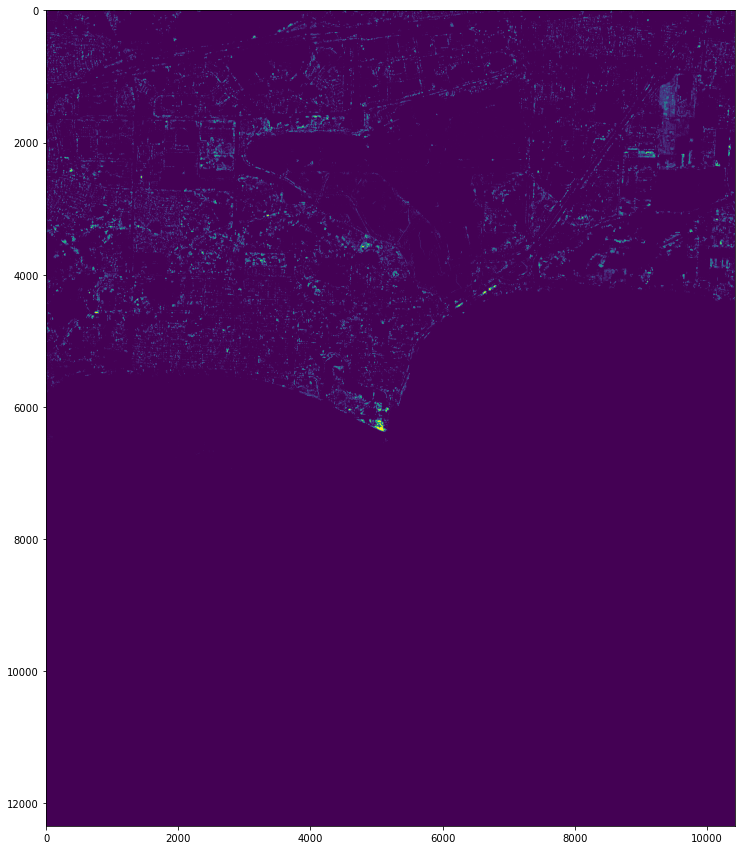

In [34]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(preds_image)
plt.show()

In [35]:
# save if necessary

if save_raster == True:
    with rasterio.open(
        os.path.join(os.getcwd(),'temp',filename),  # file path
        'w',           # w = write
        driver='GTiff', # format
        height = preds_image.shape[0], 
        width = preds_image.shape[1],
        count = 1,  # number of raster bands in the dataset
        dtype = rasterio.uint8,
        crs = naip_scene.rio.crs,
        transform = naip_scene.rio.transform(),
    ) as dst:
        dst.write(preds_image.astype(rasterio.uint8), 1)

In [36]:
# clean memory
del naip_scene, scene_features
del preds_image, predictions
gc.collect()

39

In [37]:
print('total time:', time.time() - t_alpha )

total time: 254.0621030330658
